## Beam Block
Creating beamblock functions that use wradlib to retrieve PBB and CBB. beamblock flags are then created and the PBB, CBB and flags are converted into fields in an empty radar object.

In [1]:
import matplotlib.pyplot as plt
import gdal
import osr
import numpy as np
from mpl_toolkits.basemap import Basemap
import netCDF4
import re
import pyart
import wradlib as wrl
import matplotlib
from matplotlib import cm
from IPython.display import Image, display
from mpl_toolkits.basemap import Basemap
get_ipython().magic(
    'install_ext https://raw.github.com/cpcloud/ipython-\
autotime/master/autotime.py')
get_ipython().magic('load_ext autotime')


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



ERROR:root:Line magic function `%install_ext` not found.


In [115]:
"""
pyart.retrieve.beam_block_calc
=======================================

Calculates partial beam block(PBB) and cumulative beam block(CBB)
by using wradlib's beamblock and geotiff functions. PBB and CBB
are then used to created flags when a certain beam block fraction
is passed. Empty radar object is created using Py-ART and then
is filled with beam block data.

.. autosummary::
    :toctreeL generated/
    :template: dev_template.rst

    beam_block
    empty_radar_beam_block_ppi
    beam_block_flag
    _arrays_to_dict
    _flags_to_dict

"""

import pyart
import numpy as np
import wradlib as wrl


def beam_block(radar, tif_name,
               beam_width=1.0, **kwargs):
    """
    Beam Block Calculation

    Parameters
    ----------
    radar : Radar
        Radar object used.
    tif_name : string
        Name of geotiff file to use for the
        calculation

    Other Parameters
    ----------------
    beam_width : float
        Radar's beam width for calculation.
        Default value is 1.0.

    Returns
    -------
    pbb : array
        Array of partial beam block fractions for each
        gate in each ray.
    cbb: array
        Array of cumulative beam block fractions for
        each gate in each ray.

    References
    ----------
    Bech, J., B. Codina, J. Lorente, and D. Bebbington,
    2003: The sensitivity of single polarization weather
    radar beam blockage correction to variability in the
    vertical refractivity gradient. J. Atmos. Oceanic
    Technol., 20, 845–855

    Heistermann, M., Jacobi, S., and Pfaff, T., 2013:
    Technical Note: An open source library for processing
    weather radar data (wradlib), Hydrol. Earth Syst.
    Sci., 17, 863-871, doi:10.5194/hess-17-863-2013
    
    Helmus, J.J. & Collis, S.M., (2016). The Python ARM
    Radar Toolkit (Py-ART), a Library for Working with
    Weather Radar Data in the Python Programming Language.
    Journal of Open Research Software. 4(1), p.e25.
    DOI: http://doi.org/10.5334/jors.119

    """

    radar.fields.clear()
    _range = radar.range['data']
    beamradius = wrl.util.half_power_radius(_range, beam_width)

    rasterfile = tif_name
    data_raster = wrl.io.open_raster(rasterfile)
    proj_raster = wrl.georef.wkt_to_osr(data_raster.GetProjection())
    rastercoords, rastervalues = wrl.io.read_raster_data(rasterfile)
    sitecoords = (np.float(radar.longitude['data']),
                  np.float(radar.latitude['data']),
                  np.float(radar.altitude['data']))

    pbb_arrays = []
    cbb_arrays = []

    for i in range(len(radar.sweep_start_ray_index['data'])):
        index_start = radar.sweep_start_ray_index['data'][i]
        index_end = radar.sweep_end_ray_index['data'][i]

        #nrays = index_end - index_start + 1
        #nbins = radar.ngates
        #range_res = (np.max(_range) - np.min(_range)) / (nbins - 1)
        #range_res = _range[1] - _range[0]
        #range_res = wrl.georef._get_range_resolution(_range)
        #elev = radar.fixed_angle['data'][i]
        elevs = radar.elevation['data'][index_start:index_end + 1]
        azimuths = radar.azimuth['data'][index_start:index_end + 1]
        rg, azg = np.meshgrid(_range, azimuths)
        rg, eleg = np.meshgrid(_range, elevs)
        lon, lat, alt = wrl.georef.polar2lonlatalt_n(
            rg, azg, eleg, sitecoords, **kwargs)

        #lon = radar.gate_longitude['data'][index_start:index_end +1]
        #lat = radar.gate_latitude['data'][index_start:index_end + 1]
        #alt = radar.gate_altitude['data'][index_start:index_end + 1]
        x_pol, y_pol = wrl.georef.reproject(
            lon, lat, projection_target=proj_raster)
        polcoords = np.dstack((x_pol, y_pol))

        rlimits = (x_pol.min(), y_pol.min(), x_pol.max(), y_pol.max())
        # Clip the region inside our bounding box
        ind = wrl.util.find_bbox_indices(rastercoords, rlimits)
        rastercoords = rastercoords[ind[1]:ind[3], ind[0]:ind[2], ...]
        rastervalues = rastervalues[ind[1]:ind[3], ind[0]:ind[2]]

        # Map rastervalues to polar grid points
        polarvalues = wrl.ipol.cart2irregular_spline(
            rastercoords, rastervalues, polcoords, **kwargs)

        pbb = wrl.qual.beam_block_frac(polarvalues, alt, beamradius)
        pbb = np.ma.masked_invalid(pbb)
        pbb_arrays.append(pbb)

        maxindex = np.nanargmax(pbb, axis=1)
        cbb = np.copy(pbb)
        # Iterate over all beams
        for ii, index in enumerate(maxindex):
            premax = 0.
            for jj in range(index):
                # Only iterate to max index to make this faster
                if pbb[ii, jj] > premax:
                    cbb[ii, jj] = pbb[ii, jj]
                    premax = pbb[ii, jj]
                else:
                    cbb[ii, jj] = premax
            # beyond max index, everything is max anyway
            cbb[ii, index:] = pbb[ii, index]
        cbb_arrays.append(cbb)

    pbb_all = np.ma.concatenate(pbb_arrays)
    cbb_all = np.ma.concatenate(cbb_arrays)
    return pbb_all, cbb_all

def beam_block_flag(pbb_all, cbb_all, pbb_threshold,
                    cbb_threshold):
    """ Takes PBB and CBB arrays created from the
    beam_block function and user chosen thresholds
    to create and array of 1s and 0s, 1 is a flagged gate
    where the fraction value is past the threshold. """
    pbb_flags = np.empty_like(pbb_all)
    pbb_flags[pbb_all > pbb_threshold] = 1
    pbb_flags[pbb_all < pbb_threshold] = 0

    cbb_flags = np.empty_like(cbb_all)
    cbb_flags[cbb_all > cbb_threshold] = 1
    cbb_flags[cbb_all < cbb_threshold] = 0
    return pbb_flags, cbb_flags

def empty_radar_beam_block_ppi(ngates, rays_per_sweep, nsweeps,
                               lon, lat, alt, range_start,
                               gate_space, elevations):
    """ Creates a radar object with no fields based on
    user inputed dimensions. The empty radar is to then
    be used to add PBB, CBB and the flags for both. """
    radar = pyart.testing.make_empty_ppi_radar(
        ngates, rays_per_sweep, nsweeps)
    radar.longitude['data'] = np.array([lon])
    radar.latitude['data'] = np.array([lat])
    radar.altitude['data'] = np.array([alt])
    radar.azimuth['data'] = np.linspace(0, 360, rays_per_sweep)
    radar.range['data'] = np.linspace(
        range_start, (ngates - 1)*gate_space + range_start, ngates)
    radar.fixed_angle['data'] = elevations
    radar.elevation['data'] = np.array([elevations] * rays_per_sweep)
    radar.metadata['instrument_name'] = 'beam_block_radar_object'
    return radar

def _arrays_to_dict(pbb_all, cbb_all):
    """ Function that takes the PBB and CBB arrays
    and turns them into dictionaries to be used and added
    to the pyart radar object. """
    pbb_dict = {}
    pbb_dict['coordinates'] = 'elevation, azimuth, range'
    pbb_dict['units'] = 'unitless'
    pbb_dict['data'] = pbb_all
    pbb_dict['standard_name'] = 'partial_beam_block'
    pbb_dict['long_name'] = 'Partial Beam Block Fraction'
    pbb_dict['comment'] = 'Partial beam block fraction due to terrain'

    cbb_dict = {}
    cbb_dict['coordinates'] = 'elevation, azimuth, range'
    cbb_dict['units'] = 'unitless'
    cbb_dict['data'] = cbb_all
    cbb_dict['standard_name'] = 'cumulative_beam_block'
    cbb_dict['long_name'] = 'Cumulative Beam Block Fraction'
    cbb_dict['comment'] = 'Cumulative beam block fraction due to terrain'
    return pbb_dict, cbb_dict

def _flags_to_dict(pbb_flags, cbb_flags):
    """ Function that takes the PBB_flag and CBB_flag
    arrays and turns them into dictionaries to be used
    and added to the pyart radar object. """
    pbb_flag_dict = {}
    pbb_flag_dict['units'] = 'unitless'
    pbb_flag_dict['data'] = pbb_flags
    pbb_flag_dict['standard_name'] = 'partial_beam_block_flag'
    pbb_flag_dict['long_name'] = 'Partial Beam Block Flag'
    pbb_flag_dict['comment'] = 'Partial beam block fraction flag, ' \
                            '1 for flagged values, 0 for non-flagged.'

    cbb_flag_dict = {}
    cbb_flag_dict['units'] = 'unitless'
    cbb_flag_dict['data'] = cbb_flags
    cbb_flag_dict['standard_name'] = 'cumulative_beam_block_flag'
    cbb_flag_dict['long_name'] = 'Cumulative Beam Block Flag'
    cbb_flag_dict['comment'] = 'Cumulative beam block fraction flag, ' \
                            '1 for flagged values, 0 for non-flagged.'
    return pbb_flag_dict, cbb_flag_dict

time: 198 ms


In [116]:
# Examples
# --------
# >>> import pyart
# >>> radar = pyart.io.read('radar_file.nc')
# >>> gatefilter = pyart.correct.GateFilter(radar)
# >>> beam_block = radar.fields['partial_beam_block_flag']['data']
# >>> gatefilter.exclude_beam_block(beam_block)

def exclude_beam_block(self, beam_block, exclude_masked=True, op='or'):
    """
    Exclude gates where a beam block is equal to True.

    Parameters
    ----------
    beam_block : numpy array
        Boolean numpy array with same shape as a field array.
    exclude_masked : bool, optional
        True to filter masked values in the specified mask if it is
        a masked array, False to include any masked values.
    op : {'and', 'or', 'new'}
        Operation to perform when merging the existing set of excluded
        gates with the excluded gates from the current operation.
        'and' will perform a logical AND operation, 'or' a logical OR,
        and 'new' will replace the existing excluded gates with the one
        generated here. 'or', the default for exclude methods, is
        typically desired when building up a set of conditions for
        excluding gates where the desired effect is to exclude gates which
        meet any of the conditions. 'and', the default for include
        methods, is typically desired when building up a set of conditions
        where the desired effect is to include gates which meet any of the
        conditions.  Note that the 'and' method MAY results in including
        gates which have previously been excluded because they were masked
        or invalid.

    """

    fdata = next(iter(self._radar.fields.values()))['data']
    if beam_block.shape != fdata.shape:
        raise ValueError("beam_block array must be the same size as a field.")
    marked = np.array(beam_block, dtype='bool')
    return self._merge(marked, op, exclude_masked)

time: 17.5 ms


In [126]:
# sitecoords = (-28.0257, 39.0916, 40.0)
elevations = np.array([0.5, 1.0, 2.0, 3.0, 4.0, 10.0, 11.0, 15.0,
                          20.0, 30.0, 40.0])
radar = empty_radar_beam_block_ppi(1700, 990, 1, -28.0257,
                                39.0916, 40.0, 0, 100,
                                elevations=2.0)
tif_name = '/home/zsherman/beam_block/data/dtm_gra.tif'

time: 3.69 ms


In [127]:
#pyart.io.write_cfradial(
#    '/home/zsherman/sample_radar.nc', radar)

time: 9.92 ms


/home/zsherman/.local/lib/python3.5/site-packages/pyart/io/cfradial.py:706: UserWarning: Warning, converting non-array to array:fixed_angle
  warnings.warn("Warning, converting non-array to array:%s" % name)


In [128]:
pbb_all, cbb_all = beam_block(
    radar, tif_name, 1.0)

time: 330 ms


/home/zsherman/anaconda3/envs/gdal_jupyter/lib/python3.5/site-packages/wradlib/qual.py:205: RuntimeWarning: invalid value encountered in sqrt
  (a ** 2 * np.arcsin(y / a)) + (np.pi * a ** 2 / 2.)
/home/zsherman/anaconda3/envs/gdal_jupyter/lib/python3.5/site-packages/wradlib/qual.py:205: RuntimeWarning: divide by zero encountered in true_divide
  (a ** 2 * np.arcsin(y / a)) + (np.pi * a ** 2 / 2.)
/home/zsherman/anaconda3/envs/gdal_jupyter/lib/python3.5/site-packages/wradlib/qual.py:205: RuntimeWarning: invalid value encountered in arcsin
  (a ** 2 * np.arcsin(y / a)) + (np.pi * a ** 2 / 2.)


In [129]:
print(pbb_all.max())
print(cbb_all.max())

0.999940287386
0.999940287386
time: 2.05 ms


In [130]:
pbb_flags, cbb_flags = beam_block_flag(
    pbb_all, cbb_all, 0.01, 0.01)

time: 4.14 ms


/home/zsherman/anaconda3/envs/gdal_jupyter/lib/python3.5/site-packages/ipykernel/__main__.py:157: RuntimeWarning: invalid value encountered in greater
/home/zsherman/anaconda3/envs/gdal_jupyter/lib/python3.5/site-packages/ipykernel/__main__.py:158: RuntimeWarning: invalid value encountered in less


In [131]:
pbb_dict, cbb_dict = _arrays_to_dict(
    pbb_all, cbb_all)
pbb_flag_dict, cbb_flag_dict = _flags_to_dict(
    pbb_flags, cbb_flags)

time: 3.65 ms


In [132]:
pbb_all.shape

(360, 360)

time: 2.3 ms


In [133]:
radar.add_field('partial_beam_block',
                pbb_dict, replace_existing=True)
radar.add_field('cumulative_beam_block',
                cbb_dict, replace_existing=True)
radar.add_field('partial_beam_block_flag',
                pbb_flag_dict, replace_existing=True)
radar.add_field('cumulative_beam_block_flag',
                cbb_flag_dict, replace_existing=True)

time: 3.08 ms


In [134]:
pyart.io.write_cfradial(
    '/home/zsherman/beam_block/data/radar_object_pbb_cbb_all_sweeps', radar)

time: 58.1 ms


/home/zsherman/.local/lib/python3.5/site-packages/pyart/io/cfradial.py:706: UserWarning: Warning, converting non-array to array:fixed_angle
  warnings.warn("Warning, converting non-array to array:%s" % name)


In [84]:
filename = '/home/zsherman/training_exercises/data/KLOT20130417_235520_V06.gz'
radar = pyart.io.read(filename)
radar.range

{'axis': 'radial_range_coordinate',
 'comment': 'Coordinate variable for range. Range to center of each bin.',
 'data': array([   2125.,    2375.,    2625., ...,  459375.,  459625.,  459875.], dtype=float32),
 'long_name': 'range_to_measurement_volume',
 'meters_between_gates': 250.0,
 'meters_to_center_of_first_gate': 2125.0,
 'spacing_is_constant': 'true',
 'standard_name': 'projection_range_coordinate',
 'units': 'meters'}

time: 1.26 s


In [85]:
bb_radar = pyart.io.read(
    '/home/zsherman/beam_block/data/radar_object_pbb_cbb_all_sweeps')

time: 166 ms


In [86]:
bb_radar.fields.keys()

dict_keys(['partial_beam_block_flag', 'cumulative_beam_block', 'cumulative_beam_block_flag', 'partial_beam_block'])

time: 1.76 ms


In [87]:
bb_radar.fields['partial_beam_block']['data']

masked_array(data =
 [[-- -- -- ..., -- -- --]
 [-- -- -- ..., -- -- --]
 [-- -- -- ..., -- -- --]
 ..., 
 [-- -- -- ..., -- -- --]
 [-- -- -- ..., -- -- --]
 [-- -- -- ..., -- -- --]],
             mask =
 [[ True  True  True ...,  True  True  True]
 [ True  True  True ...,  True  True  True]
 [ True  True  True ...,  True  True  True]
 ..., 
 [ True  True  True ...,  True  True  True]
 [ True  True  True ...,  True  True  True]
 [ True  True  True ...,  True  True  True]],
       fill_value = 9.96920996839e+36)

time: 3.91 ms


In [88]:
first_sweep = bb_radar.extract_sweeps([0])

time: 37.2 ms


In [89]:
first_sweep.azimuth['data'] = np.linspace(0, 360, 990)

time: 1.02 ms


In [90]:
PBB = first_sweep.fields['partial_beam_block']['data']

time: 924 µs


In [91]:
mask = np.argwhere(PBB > 0.0)[:, 0]
mask

array([324, 325, 326, ..., 776, 777, 778])

time: 11.5 ms


In [92]:
from collections import OrderedDict
list_two = list(OrderedDict.fromkeys(mask))

time: 1.39 ms


In [93]:
list_one = np.linspace(0, 360, 990)

time: 1.08 ms


In [94]:
list_three = list_one[list_two]

time: 688 µs


In [95]:
list_three_vals = [x for x in list_one if x not in list_three]

time: 3.15 ms


In [96]:
print(str(np.round(list_three_vals, decimals=3)))

[   0.       0.364    0.728    1.092    1.456    1.82     2.184    2.548
    2.912    3.276    3.64     4.004    4.368    4.732    5.096    5.46
    5.824    6.188    6.552    6.916    7.28     7.644    8.008    8.372
    8.736    9.1      9.464    9.828   10.192   10.556   10.92    11.284
   11.648   12.012   12.376   12.74    13.104   13.468   13.832   14.196
   14.56    14.924   15.288   15.652   16.016   16.38    16.744   17.108
   17.472   17.836   18.2     18.564   18.928   19.292   19.656   20.02
   20.384   20.748   21.112   21.476   21.84    22.204   22.568   22.932
   23.296   23.66    24.024   24.388   24.752   25.116   25.48    25.844
   26.208   26.572   26.936   27.3     27.664   28.028   28.392   28.756
   29.12    29.484   29.848   30.212   30.576   30.94    31.304   31.668
   32.032   32.396   32.76    33.124   33.488   33.852   34.216   34.58
   34.944   35.308   35.672   36.036   36.4     36.764   37.128   37.492
   37.856   38.22    38.584   38.948   39.312   39.676

In [97]:
# az_strings = (first_sweep.azimuth['data'][list_three_vals])
az_strings = list_three_vals

time: 965 µs


In [98]:
new_string = np.array(np.round(az_strings, decimals=3))

time: 1.44 ms


In [99]:
string = (', '.join([str(x) for x in new_string]))

time: 1.77 ms


In [100]:
spl = string.split(",")
new_fig_text = (','"\n".join([",".join(spl[i:i+15]) for i in range(0, len(spl), 15)]))

time: 1.74 ms


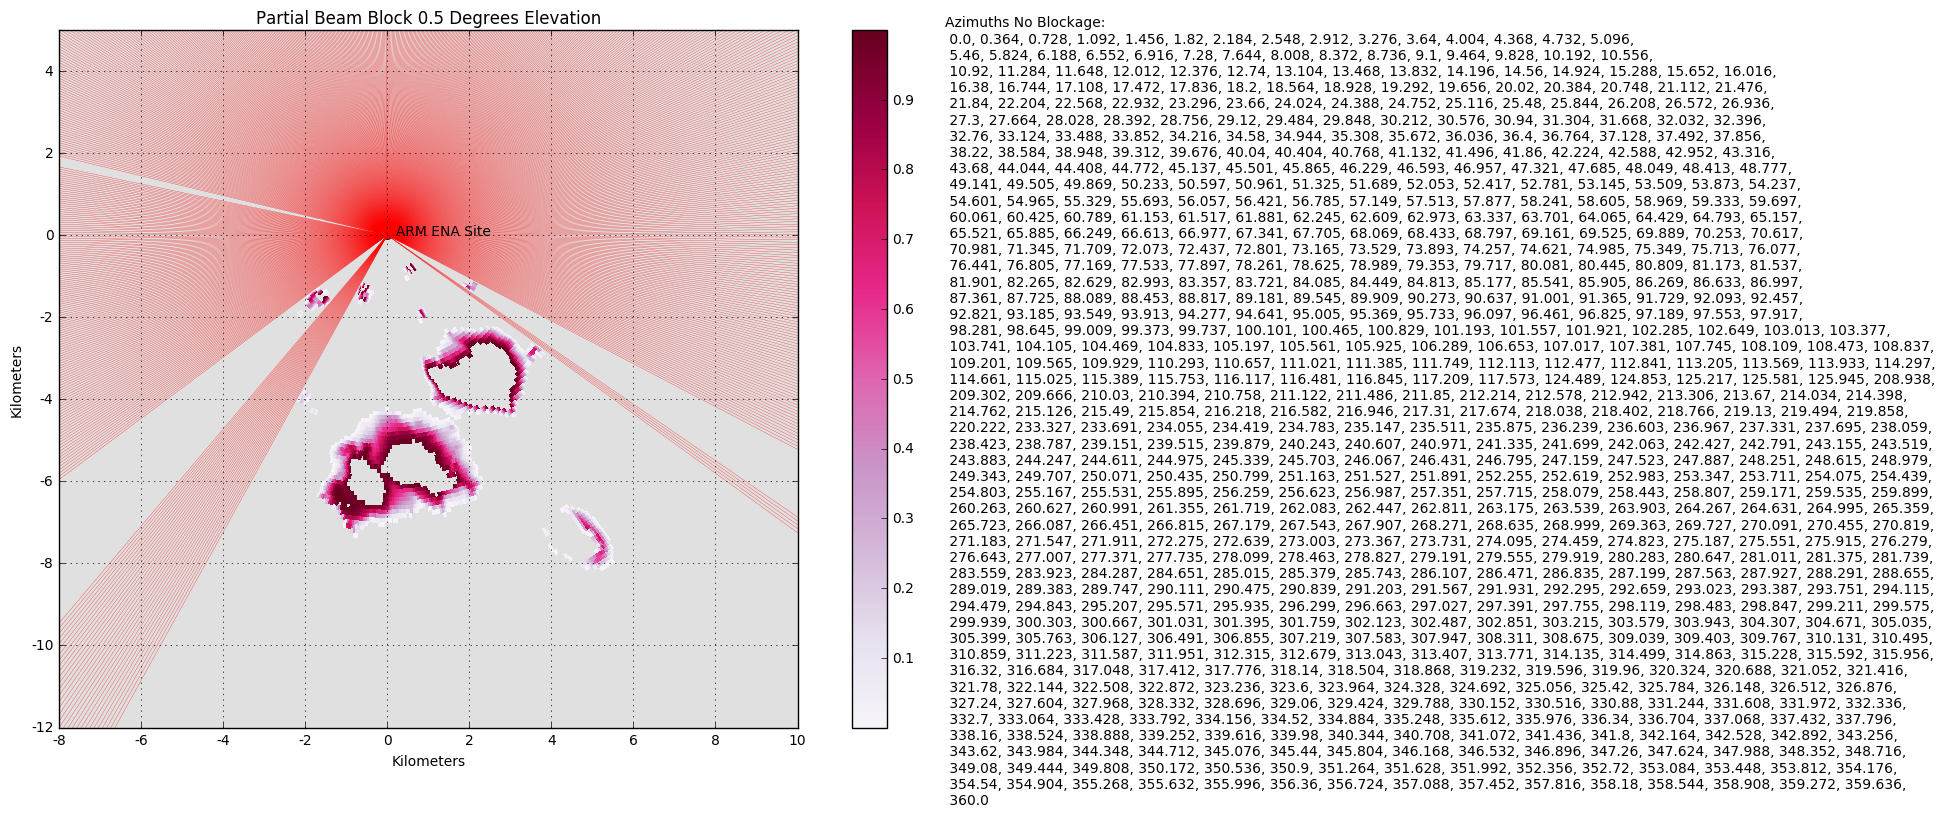

time: 4.92 s


In [101]:
PBB = first_sweep.fields['partial_beam_block']['data']
CBB = first_sweep.fields['cumulative_beam_block']['data']
r = first_sweep.range['data']
az = first_sweep.azimuth['data']
el = first_sweep.azimuth['data']
azimuths = first_sweep.azimuth['data']
fig = plt.figure(figsize=(14, 9))
ax, dem = wrl.vis.plot_ppi(PBB, r=r,
                           az=az,
                           cmap=plt.cm.PuRd)
ax.set_xlim(-8000, 10000)
ax.set_ylim(-12000, 5000)
ax.plot(0, 0, 'ro', )
for az_string in az_strings:
    ax.plot(
        [0, np.sin(np.radians(az_string))*1e5],
        [0, np.cos(np.radians(az_string))*1e5],
        "r-", linewidth=0.2)

ax.grid(True)
ax.annotate('  ARM ENA Site', (r[0], az[1]))
ticks = (ax.get_xticks()/1000).astype(np.int)
ax.set_xticklabels(ticks)
ticks = (ax.get_yticks()/1000).astype(np.int)
ax.set_yticklabels(ticks)
ax.set_title('Partial Beam Block 0.5 Degrees Elevation')
ax.set_xlabel("Kilometers")
ax.set_ylabel("Kilometers")
ax.set_axis_bgcolor('#E0E0E0')
plt.colorbar(dem, ax=ax)
plt.figtext(.85, .04, ('Azimuths No Blockage:\n ' + new_fig_text))
plt.savefig(
    '/home/zsherman/beam_block/images/graciaso_0.5elev_azimuths_no_blockage.png',
    bbox_inches='tight')
plt.show()

In [102]:
def convertXY(xy_source, inproj, outproj):
    # function to convert coordinates

    shape = xy_source[0, :, :].shape
    size = xy_source[0, :, :].size

    # the ct object takes and returns pairs of x,y, not 2d grids
    # so the the grid needs to be reshaped (flattened) and back.
    ct = osr.CoordinateTransformation(inproj, outproj)
    xy_target = np.array(ct.TransformPoints(xy_source.reshape(2, size).T))

    xx = xy_target[:, 0].reshape(shape)
    yy = xy_target[:, 1].reshape(shape)

    return xx, yy

time: 3.6 ms


In [103]:
llcrnrlat=39
urcrnrlon=-27.9
llcrnrlon=-28.1
urcrnrlat=39.1
lats = np.arange(llcrnrlat, urcrnrlat, .02)
lons = np.arange(llcrnrlon, urcrnrlon, .04)

time: 2.7 ms


In [104]:
m = Basemap(projection='lcc', lon_0=-28, lat_0=39, resolution='c', 
           llcrnrlon=llcrnrlon, llcrnrlat=llcrnrlat,
            urcrnrlon=urcrnrlon, urcrnrlat=urcrnrlat)

time: 209 ms


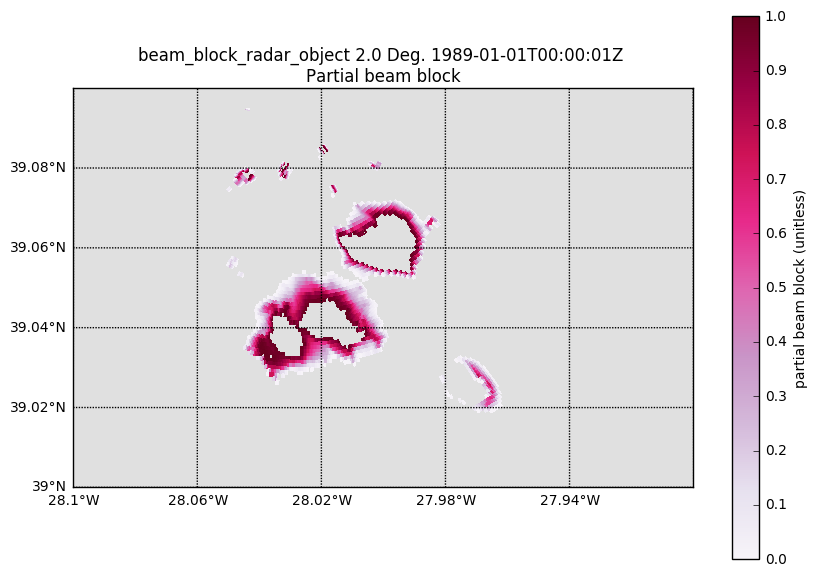

time: 1.18 s


In [105]:
angle = 131
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111)
#ax.set_ylim(-9, 2)
#ax.set_xlim(-3, 6)
ax.set_axis_bgcolor('#E0E0E0')
plt.plot([0,np.sin(np.radians(angle))*1e5],
         [0,np.cos(np.radians(angle))*1e5], "r-")
display2 = pyart.graph.RadarMapDisplay(first_sweep)
display2.plot_ppi_map(
    'partial_beam_block', vmin=0, vmax=1, basemap=m,
     lat_lines=lats, lon_lines=lons, cmap=plt.cm.PuRd)
plt.show()

In [69]:
ra =  pyart.io.read('/home/zsherman/training_exercises/data/KLOT20130417_235520_V06.gz')

time: 1.34 s


In [70]:
ds = gdal.Open("/home/zsherman/beam_block/data/dtm_gra.tif")

data = ds.ReadAsArray()
gt = ds.GetGeoTransform()
proj = ds.GetProjection()


xres = gt[1]
yres = gt[5]

# get the edge coordinates and add half the resolution 
# to go to center coordinates
xmin = gt[0] + xres * 0.5
xmax = gt[0] + (xres * ds.RasterXSize) - xres * 0.5
ymin = gt[3] + (yres * ds.RasterYSize) + yres * 0.5
ymax = gt[3] - yres * 0.5

ds = None

# create a grid of xy coordinates in the original projection
xy_source = np.mgrid[xmin:xmax+xres:xres, ymax+yres:ymin:yres]

time: 60.8 ms


In [71]:
llcrnrlat=39
urcrnrlon=-27.9
llcrnrlon=-28.1
urcrnrlat=39.1
lats = np.arange(llcrnrlat, urcrnrlat, .04)
lons = np.arange(llcrnrlon, urcrnrlon, .04)

fig = plt.figure(figsize=(12, 7))
m = Basemap(projection='lcc', lon_0=-28, lat_0=39, resolution='c', 
            llcrnrlon=llcrnrlon, llcrnrlat=llcrnrlat,
            urcrnrlon=urcrnrlon, urcrnrlat=urcrnrlat)

inproj = osr.SpatialReference()
inproj.ImportFromWkt(proj)
# Get the target projection from the basemap object
outproj = osr.SpatialReference()
outproj.ImportFromProj4(m.proj4string)

# Convert from source projection to basemap projection
xx, yy = convertXY(xy_source, inproj, outproj)

elev = data.T
the_sea = data.T < 0.1
masked_data = np.ma.masked_where(the_sea, elev)

time: 1.18 s


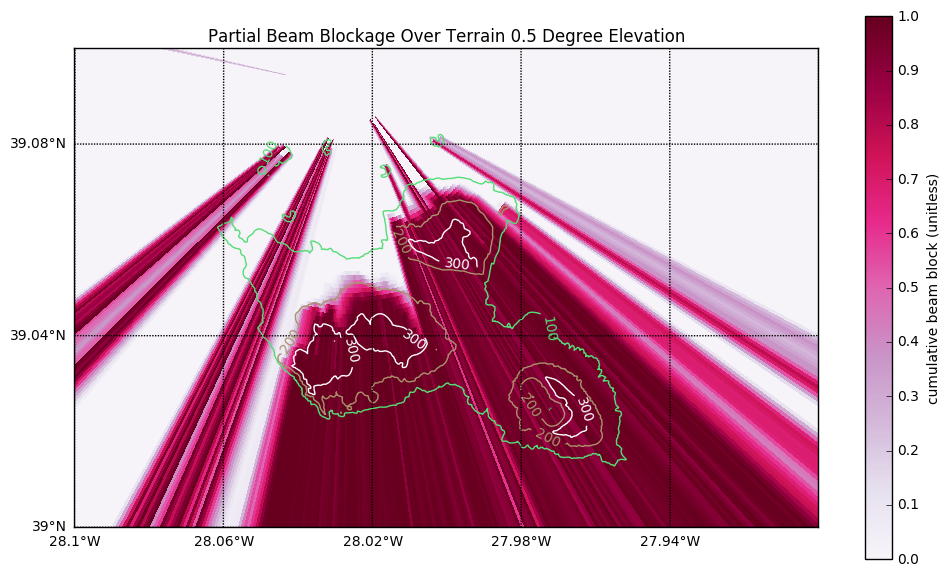

time: 1.56 s


In [72]:
title = 'Partial Beam Blockage Over Terrain 0.5 Degree Elevation'
my_display = pyart.graph.RadarMapDisplay(first_sweep)
my_display.plot_ppi_map('cumulative_beam_block', basemap=m,
                       lat_lines=lats, lon_lines=lons,
                       vmin=0, vmax=1, cmap=plt.cm.PuRd,
                       title=title)

CS = m.contour(xx, yy, masked_data,
               levels=np.arange(0, 400, 100),
               linewidths=1, cmap=plt.cm.terrain)

plt.clabel(CS, inline=1, fontsize=10, fmt='%1.0f')
plt.show()